# Libraries

In [5]:
import os
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from models.resnet import *
from utils import *

In [6]:
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=3)

# Configuration

In [7]:
class CFG:
    debug = False
    num_workers = 4
    batch_size = 128
    epochs = 5
    lr = 0.1
    weight_decay = 5e-4
    seed = 27
    
    rate = 0.5
    
    #LOGS
    LOGS_DIR = './logs'

In [8]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# Dataset

In [9]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [10]:
BASE_DIR = "cifar-10-batches-py"

In [11]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [12]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=CFG.seed)

In [13]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [16]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [17]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [18]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(8)


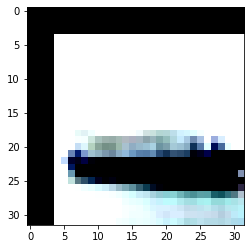

In [19]:
show_img(train_dataset[90])

In [20]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [21]:
test_dataset = CifarDataset(data, labels, transform_test)

In [22]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

# Model

In [23]:
model = ResNet56()
model.to(device)

ResNet_simple(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, 

In [33]:
model.load_state_dict(torch.load('./best_model_resnet56.pt'))

<All keys matched successfully>

# Paraphraser

In [34]:
paraphraser = Paraphraser(64, int(round(64*CFG.rate)))
paraphraser.to(device)

Paraphraser(
  (leakyrelu): LeakyReLU(negative_slope=0.1)
  (conv0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

# Helper Functions

In [35]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

# Training

In [36]:
def train_fn(train_loader, model, paraphraser, criterion, optimizer, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    paraphraser.train()
    
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        outputs = model(images)
        output_p = paraphraser(outputs[2], 0)
        
        loss = criterion(output_p, outputs[2].detach())
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg


In [37]:
criterion = nn.L1Loss()
optimizer = SGD(paraphraser.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, momentum=0.9)

In [38]:
training_logs = {'train_loss':[]}

for epoch in range(CFG.epochs):
    
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, model, paraphraser, criterion, optimizer, device)
    
    training_logs['train_loss'].append(avg_loss)
    
    print(f"Epoch {epoch+1} | Train loss: {avg_loss:.4f}")
        
    elapsed = time.time() - start_time

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:37<00:00,  9.31it/s]

Epoch 1 | Train loss: 0.3501



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:37<00:00,  9.33it/s]


Epoch 2 | Train loss: 0.1860


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:38<00:00,  9.14it/s]

Epoch 3 | Train loss: 0.1550



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:38<00:00,  9.22it/s]

Epoch 4 | Train loss: 0.1423



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 351/351 [00:36<00:00,  9.67it/s]

Epoch 5 | Train loss: 0.1373


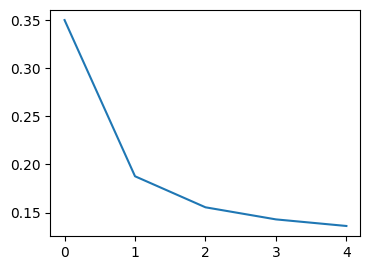

In [71]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(training_logs['train_loss'])

In [39]:
torch.save(paraphraser.state_dict(), "./paraphraser_resnet56.pt")

In [40]:
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [41]:
preds = []
valid_labels = []

model.eval()
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        outputs = model(images)
        
    preds.append(outputs[3].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 22.12it/s]


In [42]:
score

0.9344